In [1]:
# Click into this cell and press shift-enter before using this notebook.
# This line loads the ability to use %%ai in your file
# These lines import the Python modules we commonly use in CMPSC 5A
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots

# Web Scraping, CMPSC 5A, S25


This is a brief demo of web scraping.

I'm putting it into a separate Jupyter Notebook to make it clear that this is *not* a core topic we'll be exploring further in the course.

But, I'm including it because if you continue your work in Data Science, you'll eventually hear about "web scraping" so I want you to know a little bit about what it involves.

## What is web scraping

*Web scraping* refers to a technique that is used when
* There is some information that's on a web page formatted for humans
* We need to transform that information into a format that we can use as input to a data science framework (e.g. the `datascience`, `numpy` or other Python modules.)
* We can't get the information easily another way (e.g. CSV files or an API)

## Drawbacks of Web Scraping

Web scraping should typically be a "last resort", the thing we do when other approaches fail.  Here's why:

* It's generally a tedious process.
* The format of the web page can change at any time in ways that may not make any difference to a human user, but that will break our web scraping code. (This happens frequently, and often without notice).
* It often violates the *terms of service* for the web site, creating both legal and ethical issues.
* Even if you are willing to look past the legal and ethical issues, there are practical issues as well; many sites have ways of detecting scapers, and they may block your access if they think you are scaping.

## Possible consequences of unauthorized web scraping

These range from "nothing" to "severe".

This last point bears emphasizing.  If you are scraping a particular site at high volume, this may be perceived as a "denial of service hacker attack", and the web provider might block access (at least temporarily) for the entire network you are on.

That's right: you could get the *entire UCSB network* blocked from a certain website if you are perceived to be "behaving badly" with web scraping.  *This is not theoretical; I've personally seen it happen here at UCSB on at least one occasion*.

By contrast:
* Getting data from APIs and CSVs is straightforward
* The format of those can change too, but there's typically *notice* given, and there's typically *documentation* describing the change.
* The legal and ethical issues APIs and CSVs are made available in the first place,
* While there are sometimes rate limits, there's typically a lot more transparency around those, and ways of dealing with them.


## This is not intended as a full tutorial in web scraping

What I'm showing you in this notebook is just going to scratch the surface of how to
do web scraping.

* It's a single example
* I'm taking on the limitations of using *only* modules built into Python (other than `requests` which comes preinstalled in our Jupyter Hub Python Notebooks).  There are better libraries for web scraping, including `scrapy` and `beautifulsoup` that should use investigate if you need to do serious scraping

The intention here is to give you *just enough* exposure to web scraping so that you know what it is, and can determine from that whether you are interested in learning more.

## Ok, so let's do some web scraping

Suppose that the National Weather Service did *not* provide an API (they do).

Suppose that we needed to scrape the NWS page to get the weather forecast (we don't, but what if?)

Here's a URL for the Santa Barbara Weather forecast, formatted for humans. Click the link to see the page.


* <https://forecast.weather.gov/MapClick.php?zoneid=CAZ350">

Our goal will be to get the data from this part of the page into a `datascience` Table object.

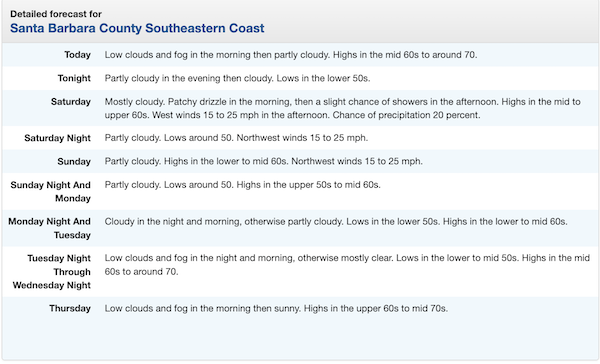

The easy part of this is getting the HTML into a variable.  We'll use the little `read_url()` function that we've seen before (it comes from the [UC Berkeley notes for Data 8](https://www.data8.org/sp23/assets/demo_html/lec01.html) that go along with our textbook)

In [4]:
# A tiny program to download text from the web.
def read_url(url):
    from urllib.request import urlopen
    import re
    return re.sub('\\s+', ' ', urlopen(url).read().decode())

weather_forecast_page_html = read_url("https://forecast.weather.gov/MapClick.php?zoneid=CAZ350")
weather_forecast_page_html[0:1024]

'<!DOCTYPE html><html class="no-js"> <head> <!-- Meta --> <meta name="viewport" content="width=device-width" /> <link rel="schema.DC" href="http://purl.org/dc/elements/1.1/" /> <title>National Weather Service</title> <meta name="DC.title" content="National Weather Service" /> <meta name="DC.description" content="NOAA National Weather Service" /> <meta name="DC.creator" content="US Department of Commerce, NOAA, National Weather Service" /> <meta name="DC.date.created" scheme="ISO8601" content="2025-05-03T23:28:34+00:00" /> <meta name="DC.language" scheme="DCTERMS.RFC1766" content="EN-US" /> <meta name="DC.keywords" content="weather" /> <meta name="DC.publisher" content="NOAA\'s National Weather Service" /> <meta name="DC.contributor" content="National Weather Service" /> <meta name="DC.rights" content="/disclaimer.php" /> <meta name="rating" content="General" /> <meta name="robots" content="index,follow" /> <!-- Icons --> <link rel="shortcut icon" href="/build/images/favicon.eab6deff.ic

So that's the HTML.  How do we get out the elements we want?

One of the first things we can do is look inside the code.  Most browsers have a feature called something like "Inspect Element" under their "Developer Tools" that you can find if you right click on a part of the web page.  Here's what that looks like in Firefox for this web page:

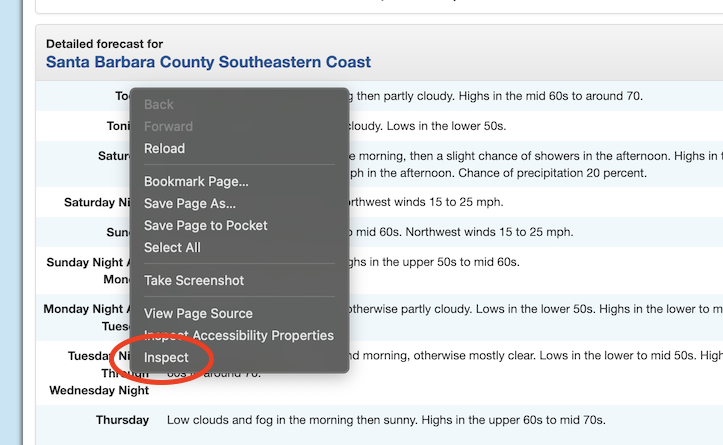

That brings up a page that looks like this, where you see the web page formatted for a human at the top of the screen, and the HTML code for the web page at the bottom of the screen.  The annotations in this image show us what we are looking for: notice the
* red circles around the text `Today` in both the formatted web page and where that occurs in the HTML code.
* blue boxes around the text `Low clouds and fog in the morning then partly cloudy. Highs in the mid 60s to around 70.` in both the formatted page and the HTML code
* the yellow boxes around `forecast-label` and `forecast-text`

Those yellow boxes are the key to our scraping strategy.  More after the image.

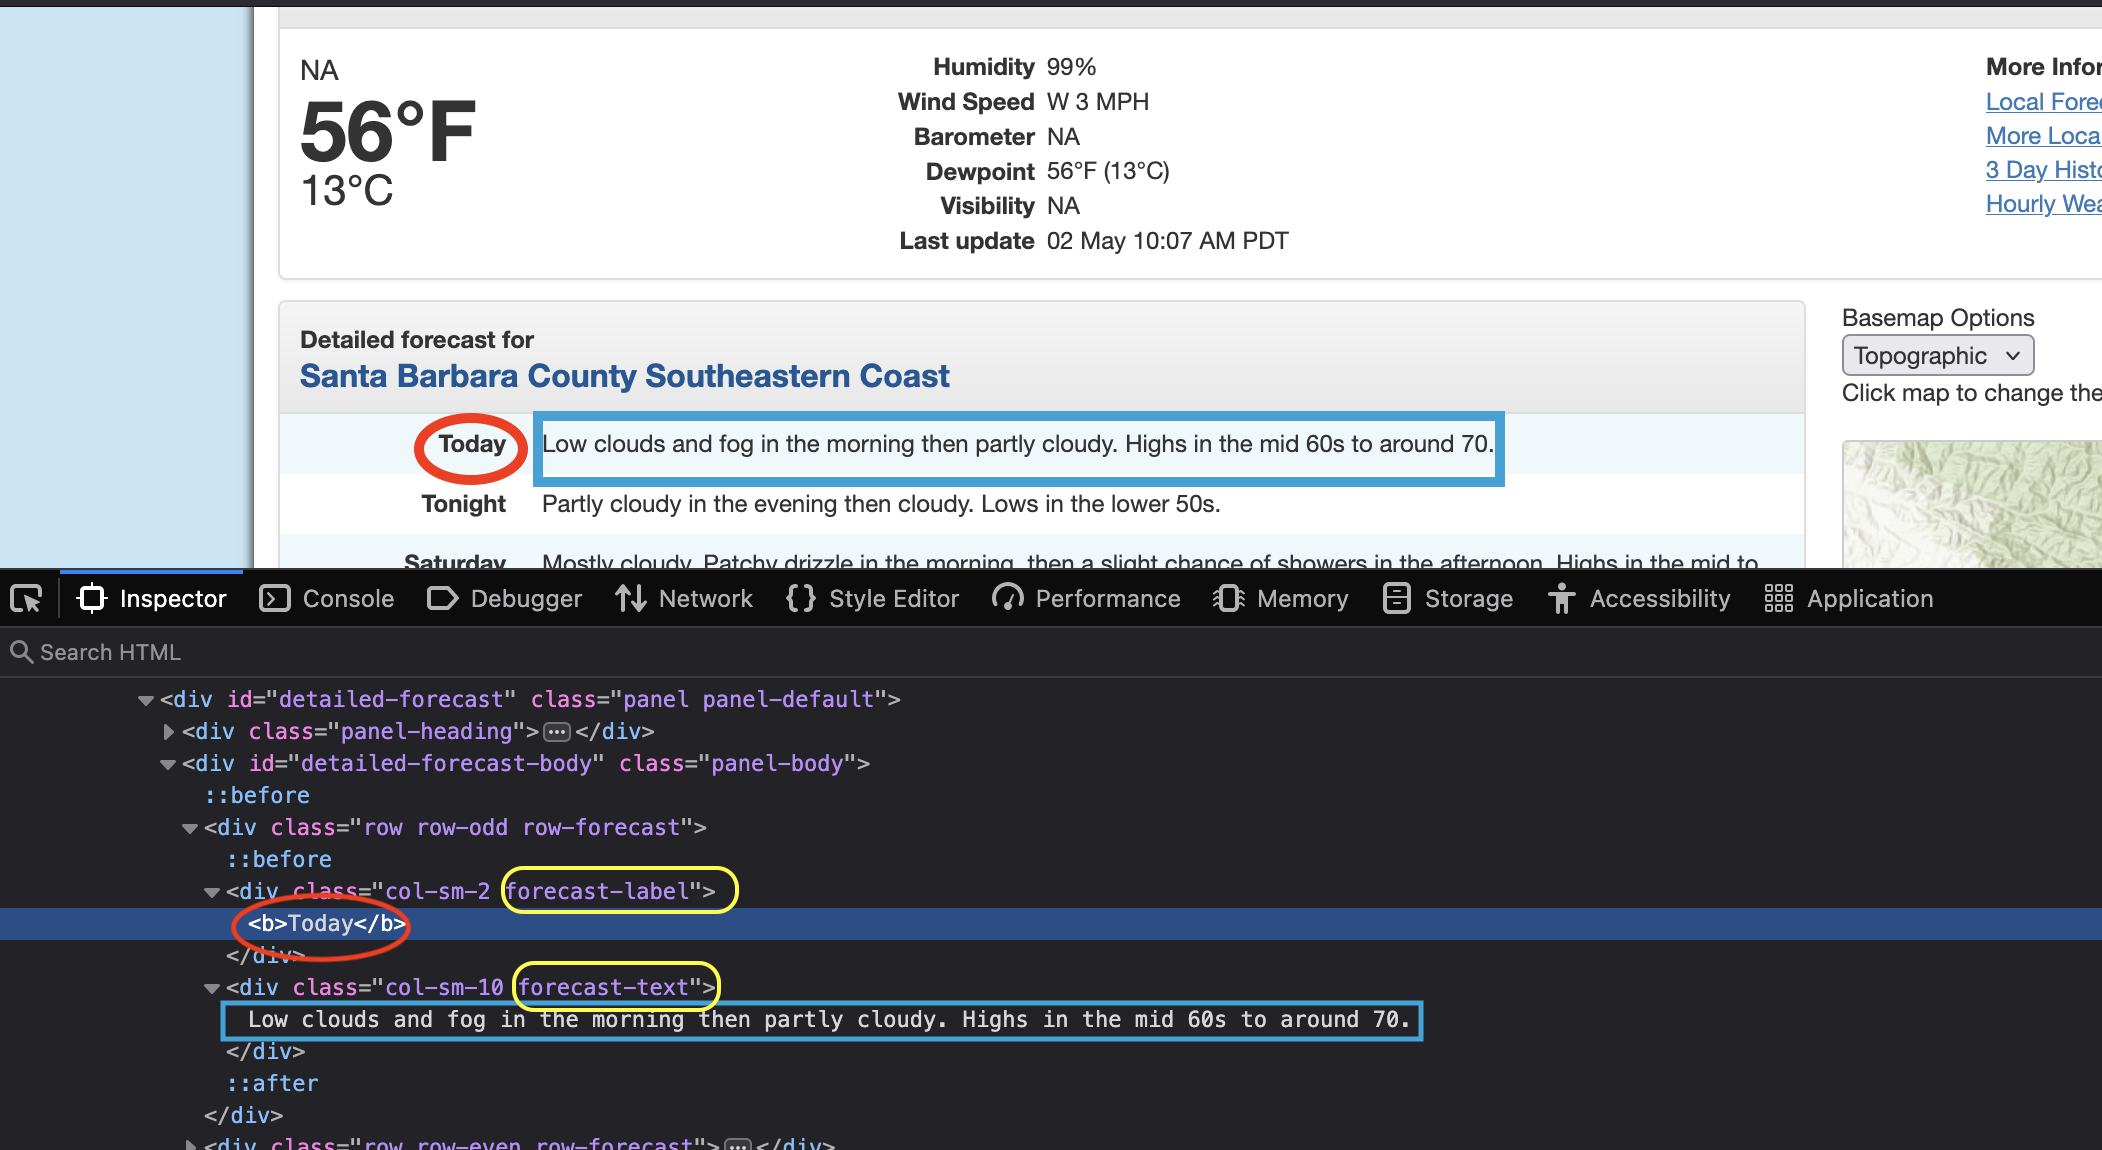

### The shortest HTML tutorial ever

We don't need to become experts in HTML to scrape it; that it we don't need the kind of HTML tutorial that you'd need if you want to *design* web pages in plain HTML.

But we do need to understand two concepts: *elements* and *attributes*

* HTML code is made up of *elements*
* Each element starts with an open tag such as `<div>` and ends with a closing tag such as `</div>`
* Elements may have *attributes* on their open tags such as `class="col-sm-2 forecast-label"`
* Elements can be nested inside one another

### A Scraping Strategy

Coming up with scraping strategy means "finding something that's true about the HTML code of *only* the things we want to pull out of the code.  It involves looking through the HTML code and the page and finding some pattern.

Here's what I came up with:

* All of the forecast labels we want to pull our are in `div` elements with a `class` attribute that contains the value `forecast-label`.
* All of the forecasts we want to pull our are in `div` elements with a `class` attribute that contains the value `forecast-text`.

We'll use that fact to pull out the data we want.

## Some code to pull out the labels

I prompted ChatGPT with this:

```
Write a Python function called extract_divs_by_class_label
that uses only modules that come standard with Python.
It should take two parameters, html_content, and class_label.
It should find all the div elements on the page that have this label
inside their class attributes, and return an array of strings with the
content of each of those div element.
```

Here's the function definition it gave me.  



In [2]:
import re
def extract_divs_by_class_label(html_content, class_label):
    # Pattern to find <div> elements whose class attribute contains the target class_label
    pattern = (
        r'<div[^>]*class=["\'][^"\']*\b' + re.escape(class_label) + r'\b[^"\']*["\'][^>]*>'
        r'(.*?)</div>'
    )

    # Find all matches for the div content
    div_contents = re.findall(pattern, html_content, re.DOTALL)

    # Function to strip all HTML tags from a string
    def strip_tags(text):
        return re.sub(r'<[^>]+>', '', text)

    # Strip HTML tags and whitespace from each match
    return [strip_tags(content).strip() for content in div_contents]

It uses a technique called *regular expressions*, which requires that we do `import re` somewhere before
this function definition.  

Regular expressions are a deep topic that could be a whole course unto themselves, so
I'm not even going to try to explain that here.

The short version is this: Regular Expressions allow you to
* specify *patterns*
* find sequences of characters that *match* those patterns.

<details>
<summary>If you want to explore that further yourself, click the triangle for some resources</summary>
<ul>
  <li><a href="https://www.w3schools.com/python/python_regex.asp">https://www.w3schools.com/python/python_regex.asp</a></li>
  <li>An entire book on Python Regular Expressions
    <ul>
      <li>Login here: <a href="https://www.oreilly.com/library-access/">https://www.oreilly.com/library-access/</a></li>
      <li>Access book here: <a href="https://learning.oreilly.com/library/view/mastering-python-regular/9781783283156/">Mastering Python Regular Expressions</a></li>
    </ul>
  </li>
</ul>
</details>

We can now use the function `extract_divs_by_class_label(html_content, class_label)`
to extract the labels, and the forecast texts:

In [5]:
forecast_labels = extract_divs_by_class_label(weather_forecast_page_html, "forecast-label")
forecast_labels

['Tonight',
 'Sunday',
 'Sunday Night',
 'Monday',
 'Monday Night',
 'Tuesday',
 'Tuesday Night',
 'Wednesday',
 'Wednesday Night',
 'Thursday',
 'Thursday Night',
 'Friday',
 'Friday Night',
 'Saturday']

In [6]:
forecast_texts = extract_divs_by_class_label(weather_forecast_page_html, "forecast-text")
forecast_texts

['Partly cloudy. A 20 percent chance of showers after midnight. Lows around 50. Northwest winds 15 to 25 mph.',
 'Partly cloudy. A 20 percent chance of showers in the morning. Highs in the mid to upper 60s. Northwest winds 15 to 25 mph.',
 'Mostly clear in the evening then partly cloudy. Lows around 50. Northwest winds around 15 mph in the evening.',
 'Partly cloudy in the morning then mostly cloudy. Highs in the lower to mid 60s.',
 'Partly cloudy in the evening then cloudy. Lows in the lower 50s.',
 'Cloudy in the morning then partly cloudy. Highs in the mid 60s.',
 'Partly cloudy early then low clouds and fog. Lows in the lower to mid 50s.',
 'Low clouds and fog in the morning then sunny. Highs in the mid 60s to around 70.',
 'Mostly clear early then low clouds and fog. Lows in the mid 50s.',
 'Low clouds and fog in the morning then sunny. Highs in the mid 60s to mid 70s.',
 'Mostly clear early then low clouds and fog. Lows in the mid 50s to around 60.',
 'Low clouds and fog in the 

And with those, we can construct a table using our normal `datascience` routines:

In [7]:
weatherTable = Table().with_columns(
    "Forecast Label", forecast_labels,
    "Forecast Text", forecast_texts
)
weatherTable

Forecast Label,Forecast Text
Tonight,Partly cloudy. A 20 percent chance of showers after midn ...
Sunday,Partly cloudy. A 20 percent chance of showers in the mor ...
Sunday Night,Mostly clear in the evening then partly cloudy. Lows aro ...
Monday,Partly cloudy in the morning then mostly cloudy. Highs i ...
Monday Night,Partly cloudy in the evening then cloudy. Lows in the lo ...
Tuesday,Cloudy in the morning then partly cloudy. Highs in the m ...
Tuesday Night,Partly cloudy early then low clouds and fog. Lows in the ...
Wednesday,Low clouds and fog in the morning then sunny. Highs in t ...
Wednesday Night,Mostly clear early then low clouds and fog. Lows in the ...
Thursday,Low clouds and fog in the morning then sunny. Highs in t ...


# Summary and wrapup

* When the data you want or need is not available in a CSV file or through an API, but is available on web pages, web scaping is an option to consider.
* Web scraping should be a last resort after exploring the other options; it can be tedious and error prone.
* There are ethical and legal issues to consider; some sites do not permit scraping.
* If you do scrape: use `time.sleep(1)` statements here and there to introduce delays to keep the load on the site you are scraping reasonable.
* Realize that
  
Tools for web scraping include:
* Using `Inspect Element` in a browser to locate patterns in the HTML corresponding to the data you want.
* Using tools such a regular expressions or modules such as `beautifulsoup` or `scrapy` to locate th data we are looking for

